In [35]:
import numpy as np
import pandas as pd
from haversine import haversine
from math import radians, cos, sin, asin, sqrt
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn import cluster as cl
from sklearn import metrics
import shapefile
import seaborn as sns


In [10]:
def dis(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r * 1000
print(dis(121.472954,31.241369,121.41989,31.23151))

5162.820149772996



stats about:
    - O1-O2 distance(x-axis), time(y-axis)
    - calculate distribution of shared-distance. vs. non-shared
    
    探索什么样的需求，能完成shared订单特征
    支持拼车的论点
    估计潜力，车辆需求的减少。
    


In [4]:
#load data
df_all= pd.read_pickle('df_all_sh_order')
#df_all=df_all.loc[df_all.cnt_of_same_trip>0]
#df_m=df_all.values
#df_m1=df_m[:,4:6].astype(object)
#print(df_m1.dtype)







In [39]:
def cal_distance(df):
    if df.shape[0]>1:
        x1=df.iloc[0]["start_long"]
        y1=df.iloc[0]["start_lat"]
        x2=df.iloc[1]["start_long"]
        y2=df.iloc[1]["start_lat"]
        #print(df.iloc[0]["label"],df.iloc)
        return dis(x1,y1,x2,y2)
    

In [62]:
df_shared=df_all[df_all["label"]!=0]
calculated=df_shared.groupby("label").apply(cal_distance).to_frame().reset_index().rename(
    columns={0: 'dist', "label": 'label'})
calculated=calculated[np.abs(calculated['dist']-calculated['dist'].mean())<=(3*calculated['dist'].std())]
calculated_np=calculated[calculated["dist"]>0]["dist"].as_matrix()
print(calculated.dist.describe())

count     330.000000
mean     1325.100241
std      1383.199556
min         0.190005
25%       442.734689
50%       876.562308
75%      1588.225662
max      6601.359322
Name: dist, dtype: float64


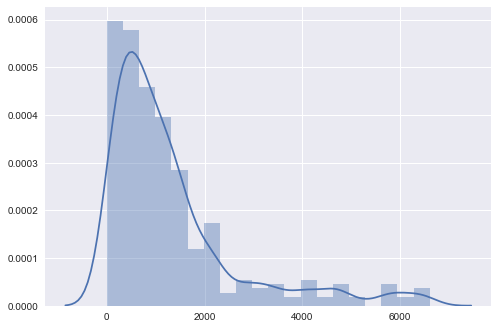

In [66]:
sns.set()
ax=sns.distplot(calculated_np)
plt.show()

In [5]:
def df_dbscan(df,ep,c1,c2):
    df_m=df.as_matrix(columns={c1,c2})
    #set up DBSCAN parameters
    kms_per_radian = 6371.0088
    epsilon = ep / kms_per_radian
    db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(df_m))
    cluster_labels = db.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([df_m[cluster_labels == n] for n in range(num_clusters)])
    print('Number of clusters: {}'.format(num_clusters))
    
    #plot
    unique_labels=set(cluster_labels)
    colors=[plt.cm.Spectral(each) for each in np.linspace(0,1,len(unique_labels))]
    fig, ax = plt.subplots(figsize=[10, 6])
    for k,col in zip(unique_labels,colors):
        if k ==-1:
            continue
        plt.plot(clusters[k][:,0], clusters[k][:,1], "o", markerfacecolor=tuple(col), alpha=0.9, markersize=2)

    ax.set_title('Full data set by start lat long')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    #ax.legend([df_scatter], ['Full set'], loc='upper right')
    plt.show()
    df_processed = df.copy()
    df_processed['Cluster'] = pd.Series(cluster_labels, index=df_processed.index)
    return df_processed

In [50]:
def df_kmeans(df,k,c1,c2):
    kmeans = cl.KMeans(n_clusters=k)
    df_m=df.as_matrix(columns={c1,c2})
    kmeans.fit(df_m)
    cluster_labels = kmeans.labels_
    num_clusters = len(set(cluster_labels))
    clusters = pd.Series([df_m[cluster_labels == n] for n in range(num_clusters)])
    #plot
    unique_labels=set(cluster_labels)
    colors=[plt.cm.Spectral(each) for each in np.linspace(0,1,len(unique_labels))]
    fig, ax = plt.subplots(figsize=[10, 6])
    for k,col in zip(unique_labels,colors):
        if k ==-1:
            continue
        plt.plot(clusters[k][:,0], clusters[k][:,1], "o", markerfacecolor=tuple(col), alpha=0.9, markersize=2)

    ax.set_title('Full data set by start lat long')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    #ax.legend([df_scatter], ['Full set'], loc='upper right')
    plt.show()
    df_processed = df.copy()
    df_processed['Cluster'] = pd.Series(cluster_labels, index=df_processed.index)
    return df_processed

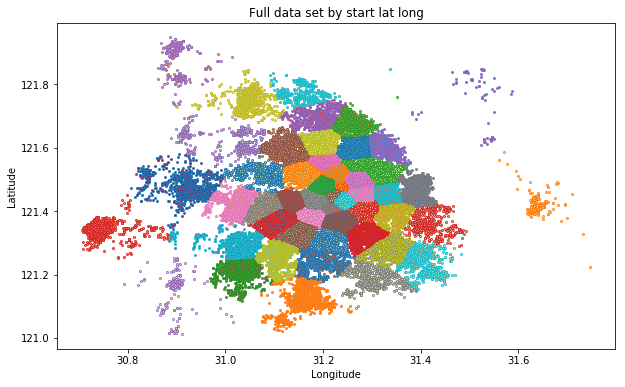

In [53]:
df1=df_kmeans(df_all,50,"start_lat","start_long")

In [63]:
def find_shared_trips(df):
    for cluster in range(0,max(df.Cluster)+1):
        sub_df=df.loc[df["Cluster"]==cluster]
        counter=0
        print("once!")
        total_shared=sum(sub_df["cnt_of_same_trip"])
        if total_shared>0:
            for i,row in sub_df.iterrows():
                if row["label"]>0:
                    counter+=1
            if total_shared-counter>3:
                print(total_shared)
                print(counter)
                print(sub_df.shape)
                return sub_df
    print("no shared trips in this group")
    df = pd.DataFrame(columns=['A'])
    return df 

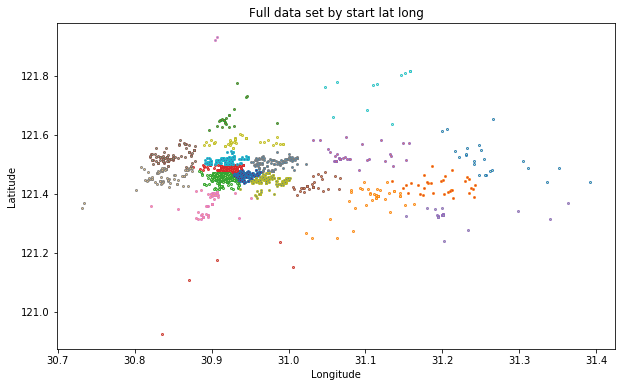

once!
once!
once!
once!
once!
once!
once!
once!
once!
once!
once!
once!
once!
once!
once!
once!
once!
once!
once!
once!
no shared trips in this group


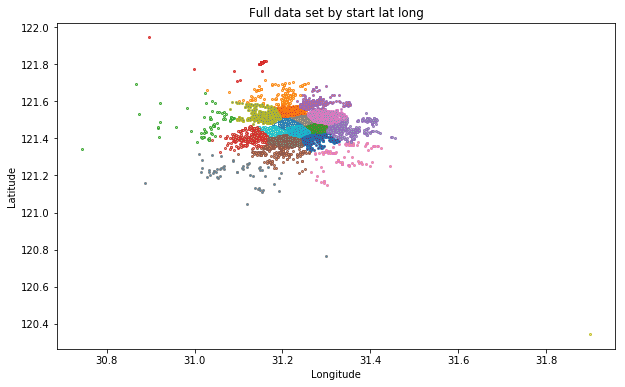

once!
42
38
(413, 14)


In [64]:
counter=0
for cluster in range(0,max(df1.Cluster)+1):
    df6=df_kmeans(df1.loc[df1["Cluster"]==cluster],20,"end_lat","end_long")
    desired=find_shared_trips(df6)
    if desired.shape[1]>1:
        break
desired.to_pickle('/Users/serenazhang/Desktop/didi_project/github/one_cluster_example')

In [62]:
print(desired.loc[desired["cnt_of_same_trip"]>1])

                               order_id                         driver_id  \
27721  71bcb4e1e13cdcd768e604f44698a1b3  edf98c5ae129e201981805c7543adabf   

                                 car_id       city  start_long  start_lat  \
27721  e3cd08707625612db7af9d0ec6cd178b  ä¸æµ·å¸   121.49203   30.91669   

        end_long   end_lat          start_time             end_time  type  \
27721  121.48274  30.91459 2016-12-23 17:39:05  2016-12-23 17:43:41  gulf   

                     label  cnt_of_same_trip  Cluster  
27721  4909302224932383763                 2       15  


In [ ]:
'''
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))

'''

Number of clusters: 126


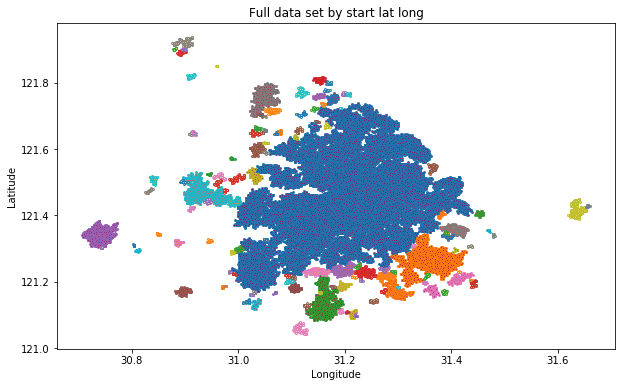

 0      227107
 1        5254
-1        3186
 2        2536
 19       2154
 4        1994
 7        1321
 11        760
 3         448
 17        410
 24        355
 16        323
 13        322
 48        282
 36        268
 8         197
 5         194
 31        182
 47        169
 25        166
 10        164
 29        140
 6         135
 15        123
 56        121
 28        117
 78         93
 51         89
 33         86
 69         81
         ...  
 115        13
 117        13
 30         13
 57         12
 97         12
 121        12
 86         12
 87         12
 118        12
 122        11
 40         11
 84         11
 58         11
 103        11
 105        11
 124        10
 66         10
 77         10
 120        10
 90         10
 119        10
 94         10
 100        10
 101        10
 114         9
 61          9
 92          9
 123         8
 89          7
 98          7
Name: Cluster, Length: 126, dtype: int64


In [21]:
df1=df_dbscan(df_all,0.5,"start_lat","start_long")
print(df1.Cluster.value_counts())

[[ 121.412758   31.231092]
 [ 121.45248    31.21716 ]
 [ 121.37295    31.344555]
 ..., 
 [ 121.46498    31.22552 ]
 [ 121.42334    31.19626 ]
 [ 121.402779   31.211241]]
Estimated number of clusters: 1


NameError: name 'labels_true' is not defined

15199
Displaying Polygons


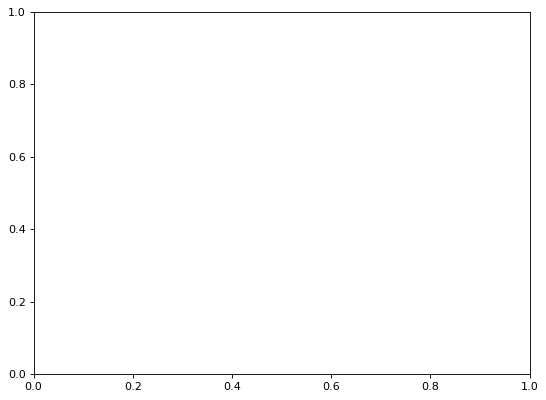

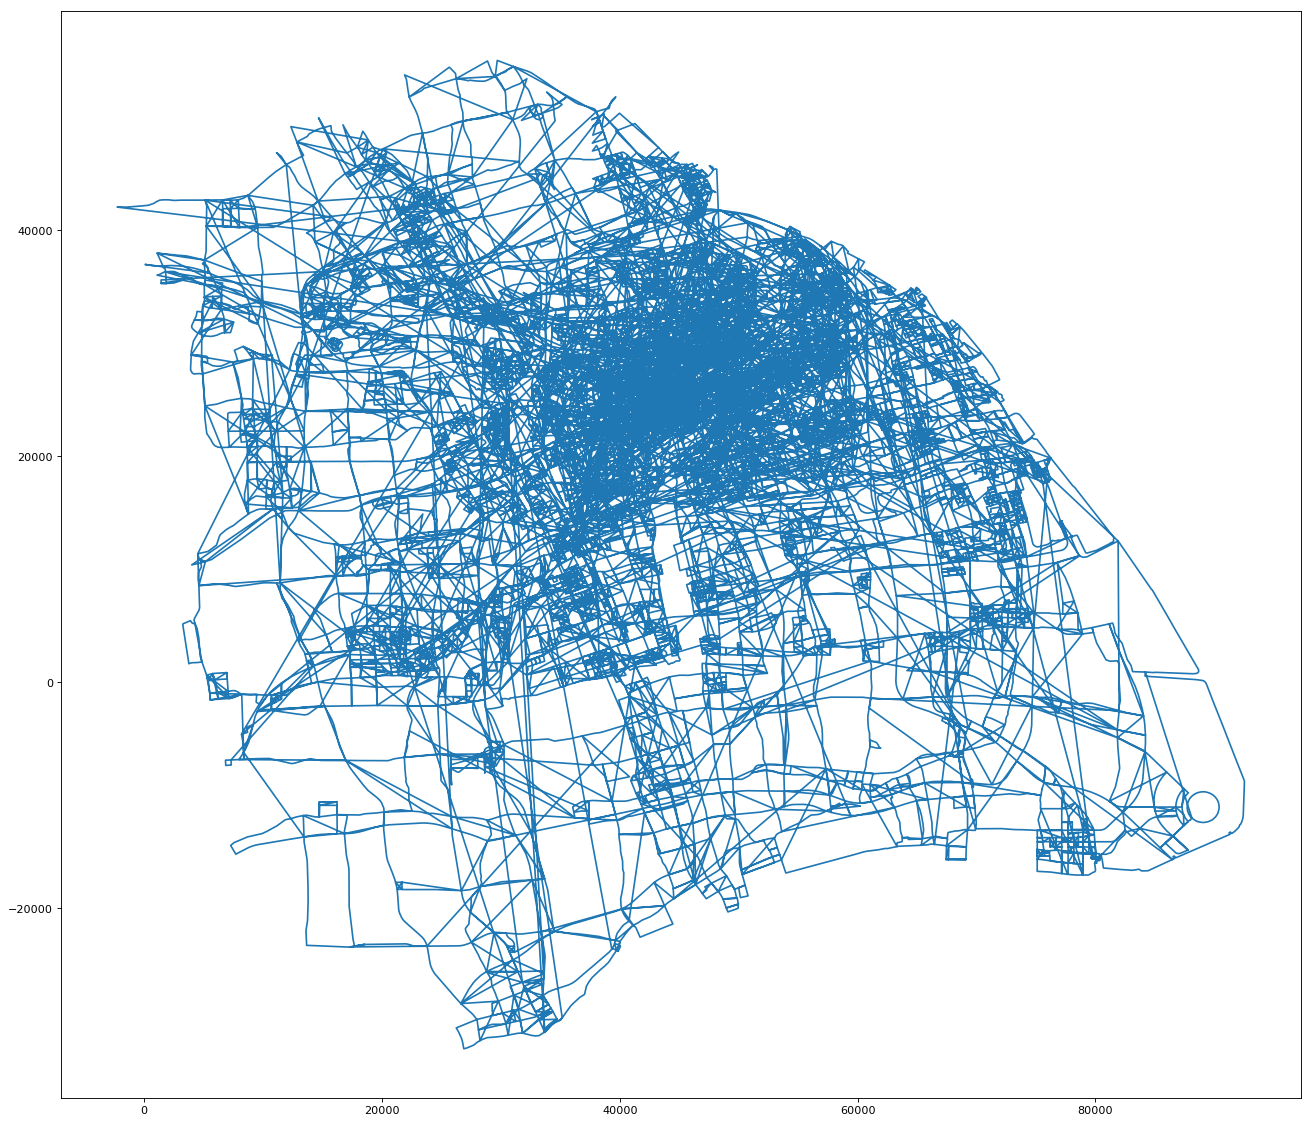

In [49]:

shpFilePath = '/Users/serenazhang/Desktop/didi_project/github/shapefile/shroad'


listx=[]
listy=[]
sf = shapefile.Reader(shpFilePath)
print(len(sf.shapes()))
fig=plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
for shape in sf.shapes():
    points = shape.points
    ap = plt.Polygon(points, fill=False, edgecolor="k")
    ax.add_patch(ap)
print("Displaying Polygons")
plt.show()

# construction of a dctionary field_name:value  
for r in sf.shapeRecords():  
     atr = dict(zip(field_names, r.record))  
plt.figure(num=None, figsize=(20,18), dpi=80, facecolor='w', edgecolor='k')
for sr in test.shapeRecords():
    for xNew,yNew in sr.shape.points:
        listx.append(xNew)
        listy.append(yNew)
plt.plot(listx,listy)
plt.show()


In [3]:

map = Basemap(
        projection='merc', llcrnrlon=70, llcrnrlat=15,
        urcrnrlon=140, urcrnrlat=55, lat_0=15, lon_0=95, resolution='l')
x,y = map(df_shared["start_long"].tolist(),df_shared["start_lat"].tolist())
map.plot(x, y, 'bo', markersize=0.1)
map.drawcoastlines()
map.drawcountries()
map.readshapefile('/Users/serenazhang/Desktop/didi_project/github/shapefile/shroad','shroad')
#map.readshapefile('/Users/serenazhang/Desktop/didi_project/github/china-latest-free/gis.osm_roads_free_1','gis.osm_roads_free_1')
plt.show()


/Users/serenazhang/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/serenazhang/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xb8 in position 0: invalid start byte

In [45]:
print(df_shared.shape)
print(df_all.shape)
df_shared_m=df_shared.as_matrix()
df_all_m=df_all.as_matrix()
similar_trips={}
count=0
for i in range(0,len(df_shared_m)):
    count+=1
    if count%1000==0:
        print(count)
    similar_trips[df_shared_m[i][0]]=[]
    start_time=df_shared_m[i][8]
    start=(df_shared_m[i][4],df_shared_m[i][5])
    for j in range(0,len(df_all_m)):
        #bigger=max(start_time,df_all_m[j][8])
        #smaller=min(start_time,df_all_m[j][8])
        time_delta=round((bigger-smaller).total_seconds()/60)
        if ((df_all_m[j][8]>start_time) and time_delta>10):
            break
        #calculate distance relevancy
        elif time_delta<=10:
            continue
            #similar_trips[df_shared_m[i][0]].append(df_all_m[j][0])
            
print(similar_trips)    
#a=df_all.iloc[0]["start_time"]
#b=df_all.iloc[10]["start_time"]
#need fix= use better destination end time 
#print(df_shared.shape)


(17682, 13)
(251062, 13)
1000
2000
3000
4000
5000
6000


KeyboardInterrupt: 

In [39]:
count=0
for index, row in df_shared.iterrows():
    count+=1
    if count%10==0:
        print(count)
    similar_trips[row["order_id"]]=[]
    start_time=row["start_time"]
    start=(row["start_long"],row["start_lat"])
    end=(row["end_long"],row["end_lat"])
    for i,r in df_all.iterrows():
        #calculate time difference
        bigger=max(start_time,r["start_time"])
        smaller=min(start_time,r["start_time"])
        time_delta=((bigger-smaller).seconds//60)%60
        print(r["start_time"])
        print(start_time)
        if ((r["start_time"]>start_time)&time_delta>1):
            print("here!")
            break
        #calculate distance relevancy
        elif time_delta<=1:
            similar_trips[row["order_id"]].append(r["order_id"])

print(len(similar_trips))

2016-12-22 00:07:41
2016-12-22 00:19:13
2016-12-22 00:07:53
2016-12-22 00:19:13
2016-12-22 00:06:15
2016-12-22 00:19:13
2016-12-22 00:05:42
2016-12-22 00:19:13
2016-12-22 00:05:39
2016-12-22 00:19:13
2016-12-22 00:09:32
2016-12-22 00:19:13
2016-12-22 00:10:56
2016-12-22 00:19:13
2016-12-22 00:21:32
2016-12-22 00:19:13
2016-12-22 00:13:20
2016-12-22 00:19:13
2016-12-22 00:15:36
2016-12-22 00:19:13
2016-12-22 00:19:13
2016-12-22 00:19:13
2016-12-22 00:17:23
2016-12-22 00:19:13
2016-12-22 00:17:11
2016-12-22 00:19:13
2016-12-22 00:18:19
2016-12-22 00:19:13
2016-12-22 00:19:38
2016-12-22 00:19:13
2016-12-22 00:27:37
2016-12-22 00:19:13
2016-12-22 00:17:51
2016-12-22 00:19:13
2016-12-22 00:18:43
2016-12-22 00:19:13
2016-12-22 00:27:57
2016-12-22 00:19:13
2016-12-22 00:22:49
2016-12-22 00:19:13
2016-12-22 00:27:43
2016-12-22 00:19:13
2016-12-22 00:28:10
2016-12-22 00:19:13
2016-12-22 00:24:47
2016-12-22 00:19:13
2016-12-22 00:29:29
2016-12-22 00:19:13
2016-12-22 00:32:55
2016-12-22 00:19:13


2016-12-22 09:02:04
2016-12-22 00:19:13
2016-12-22 08:53:17
2016-12-22 00:19:13
2016-12-22 08:57:25
2016-12-22 00:19:13
2016-12-22 09:01:32
2016-12-22 00:19:13
2016-12-22 08:58:36
2016-12-22 00:19:13
2016-12-22 08:59:33
2016-12-22 00:19:13
2016-12-22 09:05:21
2016-12-22 00:19:13
2016-12-22 08:59:17
2016-12-22 00:19:13
2016-12-22 08:55:22
2016-12-22 00:19:13
2016-12-22 09:01:57
2016-12-22 00:19:13
2016-12-22 08:59:11
2016-12-22 00:19:13
2016-12-22 09:00:43
2016-12-22 00:19:13
2016-12-22 08:59:15
2016-12-22 00:19:13
2016-12-22 09:42:55
2016-12-22 00:19:13
2016-12-22 09:20:21
2016-12-22 00:19:13
2016-12-22 09:07:47
2016-12-22 00:19:13
2016-12-22 09:00:05
2016-12-22 00:19:13
2016-12-22 08:59:08
2016-12-22 00:19:13
2016-12-22 09:01:17
2016-12-22 00:19:13
2016-12-22 08:59:05
2016-12-22 00:19:13
2016-12-22 08:58:36
2016-12-22 00:19:13
2016-12-22 09:00:19
2016-12-22 00:19:13
2016-12-22 09:08:32
2016-12-22 00:19:13
2016-12-22 09:02:13
2016-12-22 00:19:13
2016-12-22 09:03:42
2016-12-22 00:19:13


2016-12-22 11:55:41
2016-12-22 00:19:13
2016-12-22 11:50:58
2016-12-22 00:19:13
2016-12-22 11:54:21
2016-12-22 00:19:13
2016-12-22 11:54:41
2016-12-22 00:19:13
2016-12-22 11:57:28
2016-12-22 00:19:13
2016-12-22 11:54:25
2016-12-22 00:19:13
2016-12-22 11:51:36
2016-12-22 00:19:13
2016-12-22 11:55:22
2016-12-22 00:19:13
2016-12-22 11:57:30
2016-12-22 00:19:13
2016-12-22 11:55:41
2016-12-22 00:19:13
2016-12-22 11:56:56
2016-12-22 00:19:13
2016-12-22 11:53:57
2016-12-22 00:19:13
2016-12-22 11:58:46
2016-12-22 00:19:13
2016-12-22 11:57:57
2016-12-22 00:19:13
2016-12-22 11:59:07
2016-12-22 00:19:13
2016-12-22 11:59:48
2016-12-22 00:19:13
2016-12-22 12:00:31
2016-12-22 00:19:13
2016-12-22 12:03:50
2016-12-22 00:19:13
2016-12-22 12:05:02
2016-12-22 00:19:13
2016-12-22 12:06:51
2016-12-22 00:19:13
2016-12-22 11:59:55
2016-12-22 00:19:13
2016-12-22 11:58:27
2016-12-22 00:19:13
2016-12-22 12:00:38
2016-12-22 00:19:13
2016-12-22 12:02:30
2016-12-22 00:19:13
2016-12-22 12:06:27
2016-12-22 00:19:13


2016-12-22 00:19:13
2016-12-22 17:53:33
2016-12-22 00:19:13
2016-12-22 17:48:01
2016-12-22 00:19:13
2016-12-22 17:53:50
2016-12-22 00:19:13
2016-12-22 17:54:07
2016-12-22 00:19:13
2016-12-22 17:43:25
2016-12-22 00:19:13
2016-12-22 17:51:20
2016-12-22 00:19:13
2016-12-22 17:51:18
2016-12-22 00:19:13
2016-12-22 17:47:09
2016-12-22 00:19:13
2016-12-22 17:48:00
2016-12-22 00:19:13
2016-12-22 17:51:41
2016-12-22 00:19:13
2016-12-22 17:44:02
2016-12-22 00:19:13
2016-12-22 17:44:46
2016-12-22 00:19:13
2016-12-22 17:49:52
2016-12-22 00:19:13
2016-12-22 18:01:14
2016-12-22 00:19:13
2016-12-22 17:52:03
2016-12-22 00:19:13
2016-12-22 17:48:33
2016-12-22 00:19:13
2016-12-22 17:47:59
2016-12-22 00:19:13
2016-12-22 17:45:23
2016-12-22 00:19:13
2016-12-22 17:56:15
2016-12-22 00:19:13
2016-12-22 18:00:32
2016-12-22 00:19:13
2016-12-22 17:56:22
2016-12-22 00:19:13
2016-12-22 17:49:35
2016-12-22 00:19:13
2016-12-22 17:49:25
2016-12-22 00:19:13
2016-12-22 17:57:28
2016-12-22 00:19:13
2016-12-22 18:03:30


2016-12-22 00:19:13
2016-12-22 23:44:08
2016-12-22 00:19:13
2016-12-22 23:43:04
2016-12-22 00:19:13
2016-12-23 00:01:41
2016-12-22 00:19:13
2016-12-22 23:48:40
2016-12-22 00:19:13
2016-12-22 23:45:36
2016-12-22 00:19:13
2016-12-22 23:46:35
2016-12-22 00:19:13
2016-12-22 23:45:08
2016-12-22 00:19:13
2016-12-22 23:46:09
2016-12-22 00:19:13
2016-12-22 23:54:30
2016-12-22 00:19:13
2016-12-22 23:50:02
2016-12-22 00:19:13
2016-12-22 23:47:35
2016-12-22 00:19:13
2016-12-22 23:50:15
2016-12-22 00:19:13
2016-12-22 23:50:51
2016-12-22 00:19:13
2016-12-22 23:52:53
2016-12-22 00:19:13
2016-12-22 23:49:34
2016-12-22 00:19:13
2016-12-22 23:53:24
2016-12-22 00:19:13
2016-12-23 00:06:14
2016-12-22 00:19:13
2016-12-22 23:56:11
2016-12-22 00:19:13
2016-12-22 23:50:44
2016-12-22 00:19:13
2016-12-22 23:53:16
2016-12-22 00:19:13
2016-12-23 00:01:49
2016-12-22 00:19:13
2016-12-22 23:57:48
2016-12-22 00:19:13
2016-12-22 23:53:53
2016-12-22 00:19:13
2016-12-22 23:51:35
2016-12-22 00:19:13
2016-12-23 05:27:20


2016-12-22 10:24:15
2016-12-22 00:19:13
2016-12-22 10:33:26
2016-12-22 00:19:13
2016-12-22 10:21:12
2016-12-22 00:19:13
2016-12-22 10:25:03
2016-12-22 00:19:13
2016-12-22 10:30:15
2016-12-22 00:19:13
2016-12-22 10:24:27
2016-12-22 00:19:13
2016-12-22 10:32:41
2016-12-22 00:19:13
2016-12-22 10:32:18
2016-12-22 00:19:13
2016-12-22 10:26:23
2016-12-22 00:19:13
2016-12-22 10:25:56
2016-12-22 00:19:13
2016-12-22 10:29:51
2016-12-22 00:19:13
2016-12-22 10:28:08
2016-12-22 00:19:13
2016-12-22 10:33:39
2016-12-22 00:19:13
2016-12-22 10:27:48
2016-12-22 00:19:13
2016-12-22 10:31:28
2016-12-22 00:19:13
2016-12-22 10:28:24
2016-12-22 00:19:13
2016-12-22 10:31:43
2016-12-22 00:19:13
2016-12-22 10:28:55
2016-12-22 00:19:13
2016-12-22 10:30:36
2016-12-22 00:19:13
2016-12-22 10:33:51
2016-12-22 00:19:13
2016-12-22 10:30:10
2016-12-22 00:19:13
2016-12-22 10:32:15
2016-12-22 00:19:13
2016-12-22 10:30:51
2016-12-22 00:19:13
2016-12-22 10:33:25
2016-12-22 00:19:13
2016-12-22 10:33:09
2016-12-22 00:19:13


2016-12-22 16:31:09
2016-12-22 00:19:13
2016-12-22 16:26:38
2016-12-22 00:19:13
2016-12-22 16:20:46
2016-12-22 00:19:13
2016-12-22 16:25:31
2016-12-22 00:19:13
2016-12-22 16:27:25
2016-12-22 00:19:13
2016-12-22 16:25:49
2016-12-22 00:19:13
2016-12-22 16:29:39
2016-12-22 00:19:13
2016-12-22 16:32:56
2016-12-22 00:19:13
2016-12-22 16:31:21
2016-12-22 00:19:13
2016-12-22 16:25:24
2016-12-22 00:19:13
2016-12-22 16:31:54
2016-12-22 00:19:13
2016-12-22 16:34:53
2016-12-22 00:19:13
2016-12-22 16:27:57
2016-12-22 00:19:13
2016-12-22 16:32:41
2016-12-22 00:19:13
2016-12-22 16:39:14
2016-12-22 00:19:13
2016-12-22 16:39:27
2016-12-22 00:19:13
2016-12-22 16:34:10
2016-12-22 00:19:13
2016-12-22 16:36:17
2016-12-22 00:19:13
2016-12-22 16:36:40
2016-12-22 00:19:13
2016-12-22 16:42:03
2016-12-22 00:19:13
2016-12-22 16:30:38
2016-12-22 00:19:13
2016-12-22 16:31:30
2016-12-22 00:19:13
2016-12-22 16:35:58
2016-12-22 00:19:13
2016-12-22 16:35:11
2016-12-22 00:19:13
2016-12-22 16:44:34
2016-12-22 00:19:13


2016-12-22 09:42:09
2016-12-22 00:19:13
2016-12-22 09:36:06
2016-12-22 00:19:13
2016-12-22 09:44:18
2016-12-22 00:19:13
2016-12-22 09:43:03
2016-12-22 00:19:13
2016-12-22 09:44:05
2016-12-22 00:19:13
2016-12-22 09:45:12
2016-12-22 00:19:13
2016-12-22 09:39:02
2016-12-22 00:19:13
2016-12-22 09:44:28
2016-12-22 00:19:13
2016-12-22 09:54:33
2016-12-22 00:19:13
2016-12-22 09:39:25
2016-12-22 00:19:13
2016-12-22 09:45:50
2016-12-22 00:19:13
2016-12-22 09:49:22
2016-12-22 00:19:13
2016-12-22 09:40:40
2016-12-22 00:19:13
2016-12-22 09:44:04
2016-12-22 00:19:13
2016-12-22 09:41:56
2016-12-22 00:19:13
2016-12-22 09:41:46
2016-12-22 00:19:13
2016-12-22 09:45:31
2016-12-22 00:19:13
2016-12-22 09:43:30
2016-12-22 00:19:13
2016-12-22 09:46:40
2016-12-22 00:19:13
2016-12-22 09:48:19
2016-12-22 00:19:13
2016-12-22 09:49:01
2016-12-22 00:19:13
2016-12-22 09:48:11
2016-12-22 00:19:13
2016-12-22 09:48:48
2016-12-22 00:19:13
2016-12-22 09:59:36
2016-12-22 00:19:13
2016-12-22 09:41:58
2016-12-22 00:19:13


2016-12-22 16:07:54
2016-12-22 00:19:13
2016-12-22 16:09:52
2016-12-22 00:19:13
2016-12-22 16:07:25
2016-12-22 00:19:13
2016-12-22 16:09:05
2016-12-22 00:19:13
2016-12-22 16:09:26
2016-12-22 00:19:13
2016-12-22 16:13:44
2016-12-22 00:19:13
2016-12-22 16:09:58
2016-12-22 00:19:13
2016-12-22 16:14:57
2016-12-22 00:19:13
2016-12-22 16:16:27
2016-12-22 00:19:13
2016-12-22 16:10:55
2016-12-22 00:19:13
2016-12-22 16:22:38
2016-12-22 00:19:13
2016-12-22 16:12:59
2016-12-22 00:19:13
2016-12-22 16:14:18
2016-12-22 00:19:13
2016-12-22 16:18:54
2016-12-22 00:19:13
2016-12-22 16:16:01
2016-12-22 00:19:13
2016-12-22 16:15:32
2016-12-22 00:19:13
2016-12-22 16:16:37
2016-12-22 00:19:13
2016-12-22 16:18:01
2016-12-22 00:19:13
2016-12-22 16:19:08
2016-12-22 00:19:13
2016-12-22 16:28:33
2016-12-22 00:19:13
2016-12-22 16:23:41
2016-12-22 00:19:13
2016-12-22 16:18:40
2016-12-22 00:19:13
2016-12-22 16:19:39
2016-12-22 00:19:13
2016-12-22 16:16:34
2016-12-22 00:19:13
2016-12-22 16:16:22
2016-12-22 00:19:13


2016-12-23 06:11:53
2016-12-22 00:19:13
2016-12-22 19:33:20
2016-12-22 00:19:13
2016-12-22 19:41:17
2016-12-22 00:19:13
2016-12-22 19:32:15
2016-12-22 00:19:13
2016-12-22 19:36:06
2016-12-22 00:19:13
2016-12-22 19:28:05
2016-12-22 00:19:13
2016-12-22 19:32:03
2016-12-22 00:19:13
2016-12-22 19:32:55
2016-12-22 00:19:13
2016-12-22 19:31:49
2016-12-22 00:19:13
2016-12-22 19:29:29
2016-12-22 00:19:13
2016-12-22 19:28:29
2016-12-22 00:19:13
2016-12-22 19:34:16
2016-12-22 00:19:13
2016-12-22 19:33:56
2016-12-22 00:19:13
2016-12-22 19:30:59
2016-12-22 00:19:13
2016-12-22 19:35:13
2016-12-22 00:19:13
2016-12-22 19:38:07
2016-12-22 00:19:13
2016-12-22 19:35:03
2016-12-22 00:19:13
2016-12-22 19:41:46
2016-12-22 00:19:13
2016-12-22 19:49:30
2016-12-22 00:19:13
2016-12-22 19:33:50
2016-12-22 00:19:13
2016-12-22 19:34:05
2016-12-22 00:19:13
2016-12-22 19:33:26
2016-12-22 00:19:13
2016-12-22 19:32:54
2016-12-22 00:19:13
2016-12-22 19:33:55
2016-12-22 00:19:13
2016-12-22 19:33:52
2016-12-22 00:19:13


2016-12-22 00:19:13
2016-12-22 06:46:28
2016-12-22 00:19:13
2016-12-22 06:43:25
2016-12-22 00:19:13
2016-12-22 06:47:21
2016-12-22 00:19:13
2016-12-22 06:49:38
2016-12-22 00:19:13
2016-12-22 06:44:42
2016-12-22 00:19:13
2016-12-22 06:52:46
2016-12-22 00:19:13
2016-12-22 06:46:04
2016-12-22 00:19:13
2016-12-22 06:47:31
2016-12-22 00:19:13
2016-12-22 06:54:14
2016-12-22 00:19:13
2016-12-22 06:51:31
2016-12-22 00:19:13
2016-12-22 06:56:12
2016-12-22 00:19:13
2016-12-22 06:53:05
2016-12-22 00:19:13
2016-12-22 06:50:30
2016-12-22 00:19:13
2016-12-22 06:52:26
2016-12-22 00:19:13
2016-12-22 06:57:55
2016-12-22 00:19:13
2016-12-22 06:52:27
2016-12-22 00:19:13
2016-12-22 07:02:44
2016-12-22 00:19:13
2016-12-22 06:57:15
2016-12-22 00:19:13
2016-12-22 06:55:31
2016-12-22 00:19:13
2016-12-22 06:56:28
2016-12-22 00:19:13
2016-12-22 07:02:04
2016-12-22 00:19:13
2016-12-22 07:00:00
2016-12-22 00:19:13
2016-12-22 06:56:37
2016-12-22 00:19:13
2016-12-22 07:01:10
2016-12-22 00:19:13
2016-12-22 07:02:34


2016-12-22 12:56:38
2016-12-22 00:19:13
2016-12-22 12:38:27
2016-12-22 00:19:13
2016-12-22 12:35:41
2016-12-22 00:19:13
2016-12-22 12:39:39
2016-12-22 00:19:13
2016-12-22 12:33:49
2016-12-22 00:19:13
2016-12-22 12:36:48
2016-12-22 00:19:13
2016-12-22 12:35:58
2016-12-22 00:19:13
2016-12-22 12:42:04
2016-12-22 00:19:13
2016-12-22 12:39:01
2016-12-22 00:19:13
2016-12-22 12:39:53
2016-12-22 00:19:13
2016-12-22 12:40:33
2016-12-22 00:19:13
2016-12-22 12:40:19
2016-12-22 00:19:13
2016-12-22 12:42:49
2016-12-22 00:19:13
2016-12-22 12:42:50
2016-12-22 00:19:13
2016-12-22 12:40:23
2016-12-22 00:19:13
2016-12-22 12:38:13
2016-12-22 00:19:13
2016-12-22 12:37:48
2016-12-22 00:19:13
2016-12-22 12:42:47
2016-12-22 00:19:13
2016-12-22 12:41:05
2016-12-22 00:19:13
2016-12-22 12:42:43
2016-12-22 00:19:13
2016-12-22 12:43:39
2016-12-22 00:19:13
2016-12-22 12:41:51
2016-12-22 00:19:13
2016-12-22 12:41:55
2016-12-22 00:19:13
2016-12-22 12:42:42
2016-12-22 00:19:13
2016-12-22 12:48:32
2016-12-22 00:19:13


2016-12-22 00:19:13
2016-12-22 18:43:29
2016-12-22 00:19:13
2016-12-22 18:53:16
2016-12-22 00:19:13
2016-12-22 18:49:07
2016-12-22 00:19:13
2016-12-22 18:44:15
2016-12-22 00:19:13
2016-12-22 18:45:11
2016-12-22 00:19:13
2016-12-22 18:53:36
2016-12-22 00:19:13
2016-12-22 18:54:19
2016-12-22 00:19:13
2016-12-22 18:46:43
2016-12-22 00:19:13
2016-12-22 18:51:24
2016-12-22 00:19:13
2016-12-22 18:48:18
2016-12-22 00:19:13
2016-12-22 18:52:03
2016-12-22 00:19:13
2016-12-22 18:48:48
2016-12-22 00:19:13
2016-12-22 18:50:30
2016-12-22 00:19:13
2016-12-22 18:50:12
2016-12-22 00:19:13
2016-12-22 18:52:13
2016-12-22 00:19:13
2016-12-22 18:52:35
2016-12-22 00:19:13
2016-12-22 18:54:03
2016-12-22 00:19:13
2016-12-22 18:53:58
2016-12-22 00:19:13
2016-12-22 18:58:11
2016-12-22 00:19:13
2016-12-22 18:49:29
2016-12-22 00:19:13
2016-12-22 18:49:11
2016-12-22 00:19:13
2016-12-22 18:51:53
2016-12-22 00:19:13
2016-12-22 18:55:03
2016-12-22 00:19:13
2016-12-22 19:05:23
2016-12-22 00:19:13
2016-12-22 18:54:55


2016-12-22 00:19:13
2016-12-22 23:04:13
2016-12-22 00:19:13
2016-12-22 23:00:30
2016-12-22 00:19:13
2016-12-22 23:15:36
2016-12-22 00:19:13
2016-12-22 23:00:03
2016-12-22 00:19:13
2016-12-22 23:18:51
2016-12-22 00:19:13
2016-12-22 23:16:10
2016-12-22 00:19:13
2016-12-22 23:09:50
2016-12-22 00:19:13
2016-12-22 23:05:31
2016-12-22 00:19:13
2016-12-22 23:07:49
2016-12-22 00:19:13
2016-12-22 23:06:20
2016-12-22 00:19:13
2016-12-22 23:02:37
2016-12-22 00:19:13
2016-12-22 23:04:14
2016-12-22 00:19:13
2016-12-22 23:07:45
2016-12-22 00:19:13
2016-12-22 23:04:21
2016-12-22 00:19:13
2016-12-22 23:13:15
2016-12-22 00:19:13
2016-12-22 23:12:33
2016-12-22 00:19:13
2016-12-22 23:07:02
2016-12-22 00:19:13
2016-12-22 23:08:05
2016-12-22 00:19:13
2016-12-22 23:13:44
2016-12-22 00:19:13
2016-12-22 23:14:07
2016-12-22 00:19:13
2016-12-22 23:09:25
2016-12-22 00:19:13
2016-12-22 23:19:00
2016-12-22 00:19:13
2016-12-22 23:15:39
2016-12-22 00:19:13
2016-12-22 23:17:02
2016-12-22 00:19:13
2016-12-22 23:07:57


2016-12-22 21:59:28
2016-12-22 00:19:13
2016-12-22 22:06:15
2016-12-22 00:19:13
2016-12-22 21:57:50
2016-12-22 00:19:13
2016-12-22 21:59:00
2016-12-22 00:19:13
2016-12-22 22:02:58
2016-12-22 00:19:13
2016-12-22 22:01:11
2016-12-22 00:19:13
2016-12-22 22:00:19
2016-12-22 00:19:13
2016-12-22 22:02:13
2016-12-22 00:19:13
2016-12-22 22:01:49
2016-12-22 00:19:13
2016-12-22 22:06:35
2016-12-22 00:19:13
2016-12-22 22:06:03
2016-12-22 00:19:13
2016-12-22 22:24:56
2016-12-22 00:19:13
2016-12-22 22:18:24
2016-12-22 00:19:13
2016-12-22 22:04:55
2016-12-22 00:19:13
2016-12-22 22:05:37
2016-12-22 00:19:13
2016-12-22 22:05:38
2016-12-22 00:19:13
2016-12-22 22:07:38
2016-12-22 00:19:13
2016-12-22 22:07:33
2016-12-22 00:19:13
2016-12-22 22:06:06
2016-12-22 00:19:13
2016-12-22 22:15:48
2016-12-22 00:19:13
2016-12-22 22:06:30
2016-12-22 00:19:13
2016-12-22 22:15:15
2016-12-22 00:19:13
2016-12-22 22:15:40
2016-12-22 00:19:13
2016-12-22 22:14:12
2016-12-22 00:19:13
2016-12-22 22:09:49
2016-12-22 00:19:13


2016-12-22 09:08:45
2016-12-22 00:19:13
2016-12-22 09:08:48
2016-12-22 00:19:13
2016-12-22 09:10:29
2016-12-22 00:19:13
2016-12-22 09:11:29
2016-12-22 00:19:13
2016-12-22 09:15:28
2016-12-22 00:19:13
2016-12-22 09:10:45
2016-12-22 00:19:13
2016-12-22 09:12:40
2016-12-22 00:19:13
2016-12-22 09:14:19
2016-12-22 00:19:13
2016-12-22 09:08:30
2016-12-22 00:19:13
2016-12-22 09:12:22
2016-12-22 00:19:13
2016-12-22 09:18:00
2016-12-22 00:19:13
2016-12-22 09:09:57
2016-12-22 00:19:13
2016-12-22 09:13:51
2016-12-22 00:19:13
2016-12-22 09:15:42
2016-12-22 00:19:13
2016-12-22 09:15:24
2016-12-22 00:19:13
2016-12-22 10:04:44
2016-12-22 00:19:13
2016-12-22 09:20:14
2016-12-22 00:19:13
2016-12-22 09:12:32
2016-12-22 00:19:13
2016-12-22 09:12:05
2016-12-22 00:19:13
2016-12-22 09:21:49
2016-12-22 00:19:13
2016-12-22 09:33:46
2016-12-22 00:19:13
2016-12-22 09:15:36
2016-12-22 00:19:13
2016-12-22 09:20:56
2016-12-22 00:19:13
2016-12-22 09:17:38
2016-12-22 00:19:13
2016-12-22 09:14:12
2016-12-22 00:19:13


2016-12-22 15:03:11
2016-12-22 00:19:13
2016-12-22 14:55:07
2016-12-22 00:19:13
2016-12-22 14:54:48
2016-12-22 00:19:13
2016-12-22 14:50:34
2016-12-22 00:19:13
2016-12-22 15:01:20
2016-12-22 00:19:13
2016-12-22 14:51:18
2016-12-22 00:19:13
2016-12-22 14:57:26
2016-12-22 00:19:13
2016-12-22 14:53:15
2016-12-22 00:19:13
2016-12-22 14:55:27
2016-12-22 00:19:13
2016-12-22 14:52:37
2016-12-22 00:19:13
2016-12-22 15:00:14
2016-12-22 00:19:13
2016-12-22 14:53:18
2016-12-22 00:19:13
2016-12-22 14:50:45
2016-12-22 00:19:13
2016-12-22 14:52:58
2016-12-22 00:19:13
2016-12-22 14:52:00
2016-12-22 00:19:13
2016-12-22 14:57:20
2016-12-22 00:19:13
2016-12-22 14:58:29
2016-12-22 00:19:13
2016-12-22 15:03:16
2016-12-22 00:19:13
2016-12-22 14:54:13
2016-12-22 00:19:13
2016-12-22 14:57:17
2016-12-22 00:19:13
2016-12-22 14:56:34
2016-12-22 00:19:13
2016-12-22 14:56:50
2016-12-22 00:19:13
2016-12-22 14:56:15
2016-12-22 00:19:13
2016-12-22 15:02:45
2016-12-22 00:19:13
2016-12-22 14:59:37
2016-12-22 00:19:13


2016-12-22 00:19:13
2016-12-22 20:49:31
2016-12-22 00:19:13
2016-12-22 20:54:00
2016-12-22 00:19:13
2016-12-22 20:51:22
2016-12-22 00:19:13
2016-12-22 20:51:14
2016-12-22 00:19:13
2016-12-22 20:57:22
2016-12-22 00:19:13
2016-12-22 20:57:25
2016-12-22 00:19:13
2016-12-22 20:55:01
2016-12-22 00:19:13
2016-12-22 20:57:50
2016-12-22 00:19:13
2016-12-22 20:53:05
2016-12-22 00:19:13
2016-12-22 20:54:23
2016-12-22 00:19:13
2016-12-22 20:56:32
2016-12-22 00:19:13
2016-12-22 20:53:36
2016-12-22 00:19:13
2016-12-22 20:55:44
2016-12-22 00:19:13
2016-12-22 20:55:24
2016-12-22 00:19:13
2016-12-22 21:02:32
2016-12-22 00:19:13
2016-12-22 20:58:03
2016-12-22 00:19:13
2016-12-22 20:55:49
2016-12-22 00:19:13
2016-12-22 20:57:17
2016-12-22 00:19:13
2016-12-22 21:03:04
2016-12-22 00:19:13
2016-12-22 21:00:57
2016-12-22 00:19:13
2016-12-22 21:03:23
2016-12-22 00:19:13
2016-12-22 20:57:46
2016-12-22 00:19:13
2016-12-22 20:56:53
2016-12-22 00:19:13
2016-12-22 20:59:17
2016-12-22 00:19:13
2016-12-22 21:04:45


2016-12-22 00:19:13
2016-12-22 08:24:18
2016-12-22 00:19:13
2016-12-22 08:28:29
2016-12-22 00:19:13
2016-12-22 08:28:06
2016-12-22 00:19:13
2016-12-22 08:38:01
2016-12-22 00:19:13
2016-12-22 08:30:51
2016-12-22 00:19:13
2016-12-22 08:29:00
2016-12-22 00:19:13
2016-12-22 08:29:02
2016-12-22 00:19:13
2016-12-22 08:26:53
2016-12-22 00:19:13
2016-12-22 08:27:56
2016-12-22 00:19:13
2016-12-22 08:32:46
2016-12-22 00:19:13
2016-12-22 08:40:26
2016-12-22 00:19:13
2016-12-22 08:28:21
2016-12-22 00:19:13
2016-12-22 08:32:16
2016-12-22 00:19:13
2016-12-22 08:31:42
2016-12-22 00:19:13
2016-12-22 08:33:34
2016-12-22 00:19:13
2016-12-22 08:31:29
2016-12-22 00:19:13
2016-12-22 08:34:19
2016-12-22 00:19:13
2016-12-22 08:34:13
2016-12-22 00:19:13
2016-12-22 08:32:52
2016-12-22 00:19:13
2016-12-22 08:27:21
2016-12-22 00:19:13
2016-12-22 08:35:17
2016-12-22 00:19:13
2016-12-22 08:39:35
2016-12-22 00:19:13
2016-12-22 08:31:55
2016-12-22 00:19:13
2016-12-22 08:28:38
2016-12-22 00:19:13
2016-12-22 08:37:42


2016-12-22 13:35:14
2016-12-22 00:19:13
2016-12-22 13:31:36
2016-12-22 00:19:13
2016-12-22 13:35:25
2016-12-22 00:19:13
2016-12-22 13:36:09
2016-12-22 00:19:13
2016-12-22 13:29:37
2016-12-22 00:19:13
2016-12-22 13:33:12
2016-12-22 00:19:13
2016-12-22 13:38:37
2016-12-22 00:19:13
2016-12-22 13:44:02
2016-12-22 00:19:13
2016-12-22 13:34:26
2016-12-22 00:19:13
2016-12-22 13:42:22
2016-12-22 00:19:13
2016-12-22 13:36:05
2016-12-22 00:19:13
2016-12-22 13:49:59
2016-12-22 00:19:13
2016-12-22 13:41:52
2016-12-22 00:19:13
2016-12-22 13:42:19
2016-12-22 00:19:13
2016-12-22 13:43:06
2016-12-22 00:19:13
2016-12-22 13:36:07
2016-12-22 00:19:13
2016-12-22 13:51:10
2016-12-22 00:19:13
2016-12-22 13:40:00
2016-12-22 00:19:13
2016-12-22 13:43:39
2016-12-22 00:19:13
2016-12-22 13:44:32
2016-12-22 00:19:13
2016-12-22 13:39:24
2016-12-22 00:19:13
2016-12-22 13:38:06
2016-12-22 00:19:13
2016-12-22 13:45:03
2016-12-22 00:19:13
2016-12-22 13:51:17
2016-12-22 00:19:13
2016-12-22 13:40:47
2016-12-22 00:19:13


2016-12-22 17:04:41
2016-12-22 00:19:13
2016-12-22 17:21:38
2016-12-22 00:19:13
2016-12-22 17:08:33
2016-12-22 00:19:13
2016-12-22 17:10:53
2016-12-22 00:19:13
2016-12-22 17:13:36
2016-12-22 00:19:13
2016-12-22 17:06:30
2016-12-22 00:19:13
2016-12-22 17:09:38
2016-12-22 00:19:13
2016-12-22 17:07:20
2016-12-22 00:19:13
2016-12-22 17:10:26
2016-12-22 00:19:13
2016-12-22 17:06:45
2016-12-22 00:19:13
2016-12-22 17:12:46
2016-12-22 00:19:13
2016-12-22 17:25:17
2016-12-22 00:19:13
2016-12-22 17:11:16
2016-12-22 00:19:13
2016-12-22 17:08:06
2016-12-22 00:19:13
2016-12-22 17:16:01
2016-12-22 00:19:13
2016-12-22 17:27:43
2016-12-22 00:19:13
2016-12-22 17:20:03
2016-12-22 00:19:13
2016-12-22 17:14:21
2016-12-22 00:19:13
2016-12-22 17:16:35
2016-12-22 00:19:13
2016-12-22 17:12:47
2016-12-22 00:19:13
2016-12-22 17:21:15
2016-12-22 00:19:13
2016-12-22 17:14:32
2016-12-22 00:19:13
2016-12-22 17:16:12
2016-12-22 00:19:13
2016-12-22 17:17:58
2016-12-22 00:19:13
2016-12-22 17:20:59
2016-12-22 00:19:13


2016-12-22 21:16:41
2016-12-22 00:19:13
2016-12-22 21:18:59
2016-12-22 00:19:13
2016-12-22 21:22:20
2016-12-22 00:19:13
2016-12-22 21:20:43
2016-12-22 00:19:13
2016-12-22 21:19:58
2016-12-22 00:19:13
2016-12-22 21:20:03
2016-12-22 00:19:13
2016-12-22 21:22:00
2016-12-22 00:19:13
2016-12-22 21:19:31
2016-12-22 00:19:13
2016-12-22 21:18:55
2016-12-22 00:19:13
2016-12-22 21:18:30
2016-12-22 00:19:13
2016-12-22 21:21:32
2016-12-22 00:19:13
2016-12-22 21:19:39
2016-12-22 00:19:13
2016-12-22 21:22:59
2016-12-22 00:19:13
2016-12-22 21:31:16
2016-12-22 00:19:13
2016-12-22 21:24:17
2016-12-22 00:19:13
2016-12-22 21:23:55
2016-12-22 00:19:13
2016-12-22 21:30:03
2016-12-22 00:19:13
2016-12-22 21:27:13
2016-12-22 00:19:13
2016-12-22 21:29:38
2016-12-22 00:19:13
2016-12-22 21:25:25
2016-12-22 00:19:13
2016-12-22 21:27:11
2016-12-22 00:19:13
2016-12-22 21:25:19
2016-12-22 00:19:13
2016-12-22 21:29:37
2016-12-22 00:19:13
2016-12-22 21:25:32
2016-12-22 00:19:13
2016-12-22 21:26:12
2016-12-22 00:19:13


2016-12-22 00:19:13
2016-12-22 08:37:53
2016-12-22 00:19:13
2016-12-22 08:36:46
2016-12-22 00:19:13
2016-12-22 08:35:57
2016-12-22 00:19:13
2016-12-22 08:39:34
2016-12-22 00:19:13
2016-12-22 08:37:57
2016-12-22 00:19:13
2016-12-22 08:36:49
2016-12-22 00:19:13
2016-12-22 08:47:39
2016-12-22 00:19:13
2016-12-22 08:40:42
2016-12-22 00:19:13
2016-12-22 08:41:29
2016-12-22 00:19:13
2016-12-22 08:42:35
2016-12-22 00:19:13
2016-12-22 08:37:48
2016-12-22 00:19:13
2016-12-22 08:42:51
2016-12-22 00:19:13
2016-12-22 08:39:12
2016-12-22 00:19:13
2016-12-22 08:43:27
2016-12-22 00:19:13
2016-12-22 08:45:43
2016-12-22 00:19:13
2016-12-22 08:37:27
2016-12-22 00:19:13
2016-12-22 08:46:06
2016-12-22 00:19:13
2016-12-22 08:43:18
2016-12-22 00:19:13
2016-12-22 08:38:07
2016-12-22 00:19:13
2016-12-22 09:52:05
2016-12-22 00:19:13
2016-12-22 08:43:14
2016-12-22 00:19:13
2016-12-22 08:50:40
2016-12-22 00:19:13
2016-12-22 08:47:13
2016-12-22 00:19:13
2016-12-22 08:49:03
2016-12-22 00:19:13
2016-12-22 08:46:16


2016-12-22 00:19:13
2016-12-22 14:21:13
2016-12-22 00:19:13
2016-12-22 14:25:53
2016-12-22 00:19:13
2016-12-22 14:29:12
2016-12-22 00:19:13
2016-12-22 14:22:54
2016-12-22 00:19:13
2016-12-22 14:37:54
2016-12-22 00:19:13
2016-12-22 14:25:29
2016-12-22 00:19:13
2016-12-22 14:29:00
2016-12-22 00:19:13
2016-12-22 14:30:42
2016-12-22 00:19:13
2016-12-22 14:25:59
2016-12-22 00:19:13
2016-12-22 14:26:39
2016-12-22 00:19:13
2016-12-22 14:27:16
2016-12-22 00:19:13
2016-12-22 14:26:07
2016-12-22 00:19:13
2016-12-22 14:30:12
2016-12-22 00:19:13
2016-12-22 14:35:52
2016-12-22 00:19:13
2016-12-22 14:26:31
2016-12-22 00:19:13
2016-12-22 14:29:05
2016-12-22 00:19:13
2016-12-22 14:27:23
2016-12-22 00:19:13
2016-12-22 14:28:44
2016-12-22 00:19:13
2016-12-22 14:29:50
2016-12-22 00:19:13
2016-12-22 14:30:13
2016-12-22 00:19:13
2016-12-22 14:33:54
2016-12-22 00:19:13
2016-12-22 14:31:48
2016-12-22 00:19:13
2016-12-22 14:35:12
2016-12-22 00:19:13
2016-12-22 14:30:18
2016-12-22 00:19:13
2016-12-22 14:33:59


2016-12-22 00:19:13
2016-12-22 19:40:20
2016-12-22 00:19:13
2016-12-22 19:38:55
2016-12-22 00:19:13
2016-12-22 19:41:49
2016-12-22 00:19:13
2016-12-22 19:38:30
2016-12-22 00:19:13
2016-12-22 19:42:53
2016-12-22 00:19:13
2016-12-22 19:39:11
2016-12-22 00:19:13
2016-12-22 19:42:33
2016-12-22 00:19:13
2016-12-22 19:38:38
2016-12-22 00:19:13
2016-12-22 19:40:46
2016-12-22 00:19:13
2016-12-22 20:00:27
2016-12-22 00:19:13
2016-12-22 19:44:15
2016-12-22 00:19:13
2016-12-22 19:48:10
2016-12-22 00:19:13
2016-12-22 19:50:55
2016-12-22 00:19:13
2016-12-22 19:41:32
2016-12-22 00:19:13
2016-12-22 19:44:28
2016-12-22 00:19:13
2016-12-22 19:46:49
2016-12-22 00:19:13
2016-12-22 19:47:14
2016-12-22 00:19:13
2016-12-22 19:53:16
2016-12-22 00:19:13
2016-12-22 19:50:24
2016-12-22 00:19:13
2016-12-22 19:48:11
2016-12-22 00:19:13
2016-12-22 19:45:23
2016-12-22 00:19:13
2016-12-22 19:45:15
2016-12-22 00:19:13
2016-12-22 19:50:52
2016-12-22 00:19:13
2016-12-22 19:45:33
2016-12-22 00:19:13
2016-12-22 19:50:46


2016-12-22 00:19:13
2016-12-22 05:28:49
2016-12-22 00:19:13
2016-12-22 05:26:37
2016-12-22 00:19:13
2016-12-22 05:42:45
2016-12-22 00:19:13
2016-12-22 05:43:02
2016-12-22 00:19:13
2016-12-22 05:48:57
2016-12-22 00:19:13
2016-12-22 05:53:36
2016-12-22 00:19:13
2016-12-22 05:58:45
2016-12-22 00:19:13
2016-12-22 06:01:07
2016-12-22 00:19:13
2016-12-22 05:58:40
2016-12-22 00:19:13
2016-12-22 05:57:45
2016-12-22 00:19:13
2016-12-22 06:08:56
2016-12-22 00:19:13
2016-12-22 06:09:01
2016-12-22 00:19:13
2016-12-22 06:07:45
2016-12-22 00:19:13
2016-12-22 06:10:59
2016-12-22 00:19:13
2016-12-22 06:10:58
2016-12-22 00:19:13
2016-12-22 06:10:39
2016-12-22 00:19:13
2016-12-22 06:11:20
2016-12-22 00:19:13
2016-12-22 06:11:48
2016-12-22 00:19:13
2016-12-22 06:17:06
2016-12-22 00:19:13
2016-12-22 06:31:04
2016-12-22 00:19:13
2016-12-22 06:22:21
2016-12-22 00:19:13
2016-12-22 06:24:02
2016-12-22 00:19:13
2016-12-22 06:20:09
2016-12-22 00:19:13
2016-12-22 06:22:16
2016-12-22 00:19:13
2016-12-22 06:43:48


KeyboardInterrupt: 